In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.models.resnet import ResNet, Bottleneck
import numpy as np
import time
import os
import sys

# ==============================================================================
# CONFIGURATION AND HYPERPARAMETERS
# ==============================================================================
CONFIG = {
    'epochs': 200,
    'batch_size': 128,
    'learning_rate': 0.1,
    'momentum': 0.9,
    'weight_decay': 5e-4,
    'temperature': 4.0,
    'alpha': 0.9,  # 0.9 = 90% Teacher Loss, 10% CrossEntropy
    'num_workers': 4,
    'teacher_path': 'savepoints/teacher_resnet101.pth',
    'save_path': 'student_mobilenet_cifar_best.pth'
}

# ==============================================================================
# DATA PREPARATION
# ==============================================================================
def get_dataloaders():
    # Simplified augmentation pipeline to improve convergence stability
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.ToTensor(),
        transforms.Normalize((0.5071, 0.4865, 0.4409), (0.2673, 0.2564, 0.2762))
    ])

    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5071, 0.4865, 0.4409), (0.2673, 0.2564, 0.2762))
    ])

    train_set = torchvision.datasets.CIFAR100(
        root='./data', train=True, download=True, transform=transform_train
    )
    train_loader = DataLoader(
        train_set, batch_size=CONFIG['batch_size'], shuffle=True, 
        num_workers=CONFIG['num_workers'], pin_memory=True
    )

    test_set = torchvision.datasets.CIFAR100(
        root='./data', train=False, download=True, transform=transform_test
    )
    test_loader = DataLoader(
        test_set, batch_size=CONFIG['batch_size'], shuffle=False, 
        num_workers=CONFIG['num_workers'], pin_memory=True
    )

    return train_loader, test_loader

# ==============================================================================
# AUGMENTATION UTILITIES (CutMix / Mixup)
# ==============================================================================
def rand_bbox(size, lam):
    W, H = size[2], size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = int(W * cut_rat)
    cut_h = int(H * cut_rat)

    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2

def cutmix_data(x, y, alpha=1.0, device='cuda'):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1
    
    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(device)
    
    bbx1, bby1, bbx2, bby2 = rand_bbox(x.size(), lam)
    x[:, :, bbx1:bbx2, bby1:bby2] = x[index, :, bbx1:bbx2, bby1:bby2]
    
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (x.size()[-1] * x.size()[-2]))
    y_a, y_b = y, y[index]
    return x, y_a, y_b, lam

def mixup_data(x, y, alpha=1.0, device='cuda'):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1
        
    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(device)
    
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

# ==============================================================================
# MODEL DEFINITIONS
# ==============================================================================
class ResNetCIFAR(ResNet):
    def __init__(self, block, layers, num_classes=100):
        super().__init__(block, layers, num_classes=num_classes)
        # Modify input layer for CIFAR-100 (3 channels, 32x32 resolution)
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.maxpool = nn.Identity()

def load_teacher(device):
    print(f"Loading Teacher Model from {CONFIG['teacher_path']}...")
    model = ResNetCIFAR(Bottleneck, [3, 4, 23, 3], num_classes=100)
    
    if not os.path.exists(CONFIG['teacher_path']):
        raise FileNotFoundError(f"Teacher weights not found at {CONFIG['teacher_path']}")
        
    checkpoint = torch.load(CONFIG['teacher_path'], map_location=device)
    if isinstance(checkpoint, dict) and 'state_dict' in checkpoint:
        model.load_state_dict(checkpoint['state_dict'])
    else:
        model.load_state_dict(checkpoint)
        
    model.to(device)
    model.eval()
    # Freeze teacher parameters
    for param in model.parameters():
        param.requires_grad = False
    return model

def create_student(device):
    print("Initializing Student Model (MobileNetV2)...")
    model = torchvision.models.mobilenet_v2(num_classes=100)
    
    # CRITICAL FIX: Adjust first layer stride for CIFAR-100
    # Default stride is 2, which aggressively downsamples 32x32 images.
    # Setting stride to 1 preserves spatial dimensions.
    model.features[0][0].stride = (1, 1)
    
    return model.to(device)

# ==============================================================================
# TRAINING UTILITIES
# ==============================================================================
class DistillationLoss(nn.Module):
    def __init__(self, T, alpha):
        super().__init__()
        self.T = T
        self.alpha = alpha
        self.kl_div = nn.KLDivLoss(reduction='batchmean')
        self.ce_loss = nn.CrossEntropyLoss()

    def forward(self, student_logits, teacher_logits, targets):
        # Knowledge Distillation Loss (KL Divergence)
        soft_targets = F.softmax(teacher_logits / self.T, dim=1)
        soft_prob = F.log_softmax(student_logits / self.T, dim=1)
        loss_kd = self.kl_div(soft_prob, soft_targets) * (self.T ** 2)
        
        # Student Label Loss (Cross Entropy)
        loss_ce = self.ce_loss(student_logits, targets)
        
        # Combined Loss
        loss = self.alpha * loss_kd + (1 - self.alpha) * loss_ce
        return loss

def train_epoch(model, teacher, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, targets in loader:
        inputs, targets = inputs.to(device), targets.to(device)
        
        # Apply Mixup (50%) or CutMix (50%)
        r = np.random.rand()
        if r < 0.5:
            inputs, targets_a, targets_b, lam = cutmix_data(inputs, targets, alpha=1.0, device=device)
        else:
            inputs, targets_a, targets_b, lam = mixup_data(inputs, targets, alpha=1.0, device=device)
            
        with torch.no_grad():
            teacher_outputs = teacher(inputs)
            
        optimizer.zero_grad()
        student_outputs = model(inputs)
        
        loss_a = criterion(student_outputs, teacher_outputs, targets_a)
        loss_b = criterion(student_outputs, teacher_outputs, targets_b)
        loss = lam * loss_a + (1 - lam) * loss_b
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        # Approximate accuracy calculation (using primary label)
        _, predicted = student_outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        
    return running_loss / len(loader), 100. * correct / total

def evaluate(model, loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    return 100. * correct / total

# ==============================================================================
# MAIN EXECUTION
# ==============================================================================
def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"System Configuration:")
    print(f"  Device: {device}")
    if torch.cuda.is_available():
        print(f"  GPU: {torch.cuda.get_device_name(0)}")
    
    # Initialize components
    train_loader, test_loader = get_dataloaders()
    teacher_model = load_teacher(device)
    student_model = create_student(device)
    
    criterion = DistillationLoss(T=CONFIG['temperature'], alpha=CONFIG['alpha'])
    optimizer = torch.optim.SGD(
        student_model.parameters(), 
        lr=CONFIG['learning_rate'], 
        momentum=CONFIG['momentum'], 
        weight_decay=CONFIG['weight_decay'], 
        nesterov=True
    )
    
    # Cosine Annealing Scheduler
    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
        optimizer, T_0=50, T_mult=2, eta_min=1e-4
    )
    
    print(f"\nStarting training for {CONFIG['epochs']} epochs...")
    print(f"{'='*75}")
    print(f"{'Epoch':^10} | {'LR':^10} | {'Train Loss':^12} | {'Train Acc':^12} | {'Test Acc':^12}")
    print(f"{'='*75}")
    
    start_time = time.time()
    best_acc = 0.0
    
    for epoch in range(CONFIG['epochs']):
        train_loss, train_acc = train_epoch(student_model, teacher_model, train_loader, criterion, optimizer, device)
        scheduler.step()
        current_lr = optimizer.param_groups[0]['lr']
        
        # Console output for every epoch (overwrite line for cleanliness)
        print(f"[{epoch+1:03d}/{CONFIG['epochs']}] | {current_lr:.5f}    | {train_loss:.4f}       | {train_acc:.2f}%       | {'...':^12}", end='\r')
        
        # Detailed evaluation every 10 epochs or on final epoch
        if (epoch + 1) % 10 == 0 or (epoch + 1) == CONFIG['epochs']:
            test_acc = evaluate(student_model, test_loader, device)
            
            # Clear the previous overwrite line and print full stats
            print(f"{epoch+1:^10} | {current_lr:.5f}    | {train_loss:.4f}       | {train_acc:.2f}%       | {test_acc:.2f}%")
            
            if test_acc > best_acc:
                best_acc = test_acc
                torch.save(student_model.state_dict(), CONFIG['save_path'])
                print(f"  >>> New Best Model Saved (Acc: {best_acc:.2f}%)")
    
    total_time = (time.time() - start_time) / 60
    print(f"{'='*75}")
    print(f"Training Complete.")
    print(f"Total Time: {total_time:.1f} minutes")
    print(f"Best Test Accuracy: {best_acc:.2f}%")
    print(f"Model saved to: {CONFIG['save_path']}")

if __name__ == "__main__":
    main()

System Configuration:
  Device: cuda
  GPU: NVIDIA GeForce RTX 4050 Laptop GPU
Files already downloaded and verified
Files already downloaded and verified
Loading Teacher Model from savepoints/teacher_resnet101.pth...
Initializing Student Model (MobileNetV2)...

Starting training for 200 epochs...
  Epoch    |     LR     |  Train Loss  |  Train Acc   |   Test Acc  
    10     | 0.09046    | 2.6043       | 19.60%       | 36.77%     
  >>> New Best Model Saved (Acc: 36.77%)
    20     | 0.06549    | 2.3244       | 23.52%       | 48.86%     
  >>> New Best Model Saved (Acc: 48.86%)
    30     | 0.03461    | 2.0708       | 26.67%       | 54.11%     
  >>> New Best Model Saved (Acc: 54.11%)
    40     | 0.00964    | 1.7493       | 33.46%       | 63.84%     
  >>> New Best Model Saved (Acc: 63.84%)
    50     | 0.10000    | 1.4925       | 37.39%       | 69.02%     
  >>> New Best Model Saved (Acc: 69.02%)
    60     | 0.09756    | 2.4475       | 22.34%       | 42.60%     
    70     | 0.0904

In [6]:
"""
SELF-DISTILLATION (GENERATION 2)
--------------------------------
Concept: Use the best Student from Generation 1 as the Teacher for Generation 2.
Teacher: MobileNetV2 (Pre-trained ~69% Accuracy)
Student: MobileNetV2 (Freshly Initialized)
Goal: >70% Accuracy (Refinement step)
"""

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import time
import os
import sys

# ==============================================================================
# 1. CONFIGURATION
# ==============================================================================
CONFIG = {
    'epochs': 100,
    'batch_size': 128,
    'lr': 0.05,                 # Slightly lower LR for self-distillation often helps
    'momentum': 0.9,
    'weight_decay': 5e-4,
    'temperature': 4.0,         # Keep T=4.0
    'alpha': 0.9,               # Trust the peer-teacher highly
    'num_workers': 4,
    # INPUT: The best model from your previous run
    'teacher_path': 'student_mobilenet_cifar_best.pth',
    # OUTPUT: The result of this run
    'save_path': 'student_mobilenet_gen2_best.pth'
}

# Device Check
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running Generation 2 Distillation on: {device}")

# ==============================================================================
# 2. ARCHITECTURE (Must Match Gen-1 Exactly)
# ==============================================================================
def get_cifar_mobilenet(num_classes=100):
    """
    Returns MobileNetV2 with the Critical Stride Fix.
    Both Teacher (Gen-1) and Student (Gen-2) use this exact structure.
    """
    model = torchvision.models.mobilenet_v2(num_classes=num_classes)
    
    # CRITICAL: Maintain Stride=1 to match the weights from Gen-1
    # This prevents aggressive downsampling on small 32x32 images
    model.features[0][0].stride = (1, 1)
    
    return model

# ==============================================================================
# 3. DATA LOADING
# ==============================================================================
def get_dataloaders():
    # Standard Augmentation with CutMix/Mixup support in training loop
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.ToTensor(),
        transforms.Normalize((0.5071, 0.4865, 0.4409), (0.2673, 0.2564, 0.2762))
    ])

    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5071, 0.4865, 0.4409), (0.2673, 0.2564, 0.2762))
    ])

    train_set = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_train)
    train_loader = DataLoader(train_set, batch_size=CONFIG['batch_size'], shuffle=True, num_workers=CONFIG['num_workers'], pin_memory=True)

    test_set = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_test)
    test_loader = DataLoader(test_set, batch_size=CONFIG['batch_size'], shuffle=False, num_workers=CONFIG['num_workers'], pin_memory=True)

    return train_loader, test_loader

# ==============================================================================
# 4. LOADING HELPERS
# ==============================================================================
def load_gen1_teacher(path, device):
    print(f"\nLoading Teacher (Gen-1 Student) from: {path}")
    model = get_cifar_mobilenet()
    
    if not os.path.exists(path):
        print(f"ERROR: Could not find {path}")
        print("Please make sure your previous best model is in the directory.")
        sys.exit(1)
        
    checkpoint = torch.load(path, map_location=device)
    # Support both full state_dict and direct weights
    if isinstance(checkpoint, dict) and 'state_dict' in checkpoint:
        model.load_state_dict(checkpoint['state_dict'])
    elif isinstance(checkpoint, dict):
        model.load_state_dict(checkpoint)
    else:
        model.load_state_dict(checkpoint)
        
    model.to(device)
    model.eval()
    # Freeze Gen-1 Teacher
    for p in model.parameters():
        p.requires_grad = False
        
    print("Gen-1 Teacher Loaded & Frozen.")
    return model

# ==============================================================================
# 5. AUGMENTATION UTILS (CutMix/Mixup)
# ==============================================================================
def cutmix_data(x, y, alpha=1.0):
    lam = np.random.beta(alpha, alpha)
    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(device)
    
    W, H = x.size(2), x.size(3)
    cut_rat = np.sqrt(1. - lam)
    cut_w = int(W * cut_rat)
    cut_h = int(H * cut_rat)
    cx = np.random.randint(W)
    cy = np.random.randint(H)
    
    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)
    
    x[:, :, bbx1:bbx2, bby1:bby2] = x[index, :, bbx1:bbx2, bby1:bby2]
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (W * H))
    return x, y, y[index], lam

def mixup_data(x, y, alpha=1.0):
    lam = np.random.beta(alpha, alpha)
    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(device)
    mixed_x = lam * x + (1 - lam) * x[index, :]
    return mixed_x, y, y[index], lam

# ==============================================================================
# 6. LOSS & TRAINING
# ==============================================================================
class SelfDistillationLoss(nn.Module):
    def __init__(self, T, alpha):
        super().__init__()
        self.T = T
        self.alpha = alpha
        self.kl = nn.KLDivLoss(reduction='batchmean')
        self.ce = nn.CrossEntropyLoss()
        
    def forward(self, s_logits, t_logits, target):
        # KD Loss
        loss_kd = self.kl(
            F.log_softmax(s_logits / self.T, dim=1),
            F.softmax(t_logits / self.T, dim=1)
        ) * (self.T ** 2)
        
        # CE Loss
        loss_ce = self.ce(s_logits, target)
        
        return self.alpha * loss_kd + (1 - self.alpha) * loss_ce

def train_one_epoch(student, teacher, loader, optimizer, criterion):
    student.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for inputs, targets in loader:
        inputs, targets = inputs.to(device), targets.to(device)
        
        # Augmentation choice
        r = np.random.rand()
        if r < 0.5:
            inputs, targets_a, targets_b, lam = cutmix_data(inputs, targets)
        else:
            inputs, targets_a, targets_b, lam = mixup_data(inputs, targets)
            
        with torch.no_grad():
            t_out = teacher(inputs)
            
        optimizer.zero_grad()
        s_out = student(inputs)
        
        loss_a = criterion(s_out, t_out, targets_a)
        loss_b = criterion(s_out, t_out, targets_b)
        loss = lam * loss_a + (1 - lam) * loss_b
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        _, pred = s_out.max(1)
        correct += pred.eq(targets).sum().item()
        total += targets.size(0)
        
    return total_loss / len(loader), 100. * correct / total

def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)
            out = model(inputs)
            _, pred = out.max(1)
            correct += pred.eq(targets).sum().item()
            total += targets.size(0)
    return 100. * correct / total

# ==============================================================================
# 7. MAIN EXECUTION
# ==============================================================================
if __name__ == "__main__":
    train_loader, test_loader = get_dataloaders()
    
    # 1. Load the Teacher (Result from previous run)
    teacher_model = load_gen1_teacher(CONFIG['teacher_path'], device)
    
    # 2. Create fresh Student (Gen-2)
    print("Initializing fresh Gen-2 Student...")
    student_model = get_cifar_mobilenet().to(device)
    
    criterion = SelfDistillationLoss(CONFIG['temperature'], CONFIG['alpha'])
    optimizer = torch.optim.SGD(
        student_model.parameters(), 
        lr=CONFIG['lr'], 
        momentum=CONFIG['momentum'], 
        weight_decay=CONFIG['weight_decay'], 
        nesterov=True
    )
    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
        optimizer, T_0=50, T_mult=2, eta_min=1e-4
    )
    
    print(f"\nStarting Self-Distillation (Gen 1 -> Gen 2)")
    print(f"Goal: Improve upon Gen-1 baseline.")
    print(f"{'='*65}")
    print(f"{'Epoch':^10} | {'LR':^10} | {'Train Loss':^10} | {'Train Acc':^10} | {'Test Acc':^10}")
    print(f"{'='*65}")
    
    start_time = time.time()
    best_acc = 0.0
    
    for epoch in range(CONFIG['epochs']):
        t_loss, t_acc = train_one_epoch(student_model, teacher_model, train_loader, optimizer, criterion)
        scheduler.step()
        lr = optimizer.param_groups[0]['lr']
        
        # Live update
        print(f"[{epoch+1:03d}/{CONFIG['epochs']}] | {lr:.5f}    | {t_loss:.4f}     | {t_acc:.2f}%     | {'...':^10}", end='\r')
        
        # Checkpoint
        if (epoch + 1) % 10 == 0 or (epoch + 1) == CONFIG['epochs']:
            test_acc = evaluate(student_model, test_loader)
            # Clear the line to print clean status
            print(f"{epoch+1:^10} | {lr:.5f}    | {t_loss:.4f}     | {t_acc:.2f}%     | {test_acc:.2f}%")
            
            if test_acc > best_acc:
                best_acc = test_acc
                torch.save(student_model.state_dict(), CONFIG['save_path'])
                print(f"  >>> New Best Gen-2 Model Saved! ({best_acc:.2f}%)")

    print(f"\n{'='*65}")
    print(f"Gen-2 Training Complete.")
    print(f"Final Best Accuracy: {best_acc:.2f}%")
    print(f"Saved to: {CONFIG['save_path']}")

Running Generation 2 Distillation on: cuda
Files already downloaded and verified
Files already downloaded and verified

Loading Teacher (Gen-1 Student) from: student_mobilenet_cifar_best.pth
Gen-1 Teacher Loaded & Frozen.
Initializing fresh Gen-2 Student...

Starting Self-Distillation (Gen 1 -> Gen 2)
Goal: Improve upon Gen-1 baseline.
  Epoch    |     LR     | Train Loss | Train Acc  |  Test Acc 
    10     | 0.04523    | 1.1748     | 23.90%     | 48.08%   
  >>> New Best Gen-2 Model Saved! (48.08%)
    20     | 0.03276    | 0.8254     | 30.69%     | 56.67%   
  >>> New Best Gen-2 Model Saved! (56.67%)
    30     | 0.01734    | 0.6641     | 34.46%     | 63.05%   
  >>> New Best Gen-2 Model Saved! (63.05%)
    40     | 0.00487    | 0.5526     | 36.32%     | 67.05%   
  >>> New Best Gen-2 Model Saved! (67.05%)
    50     | 0.05000    | 0.5081     | 36.59%     | 69.18%   
  >>> New Best Gen-2 Model Saved! (69.18%)
    60     | 0.04878    | 0.8159     | 31.09%     | 58.53%   
    70     |

In [7]:
"""
GENERATION 3: PROGRESSIVE DISTILLATION TO TINY MODEL
----------------------------------------------------
Teacher: MobileNetV2 (Width 1.0x) | ~69% Accuracy
Student: MobileNetV2 (Width 0.5x) | ~0.7M Parameters
Goal: Extreme compression while maintaining ~65-68% Accuracy
"""

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import time
import os
import sys

# ==============================================================================
# 1. CONFIGURATION
# ==============================================================================
CONFIG = {
    'epochs': 200,
    'batch_size': 128,
    'lr': 0.05,                 # Lower learning rate for smaller capacity model
    'momentum': 0.9,
    'weight_decay': 5e-4,
    'temperature': 4.0,
    'alpha': 0.9,
    'num_workers': 4,
    # INPUT: Your best result from the previous run (Gen 1 or Gen 2)
    'teacher_path': 'student_mobilenet_cifar_best.pth', 
    # OUTPUT: The tiny model
    'save_path': 'student_mobilenet_0.5x_best.pth'
}

# Device Check
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"System Configuration:")
print(f"  Device: {device}")
if torch.cuda.is_available():
    print(f"  GPU: {torch.cuda.get_device_name(0)}")

# ==============================================================================
# 2. ARCHITECTURE DEFINITIONS
# ==============================================================================
def get_teacher_model(num_classes=100):
    """
    The Teacher is the standard MobileNetV2 (1.0x) from your previous run.
    Must have Stride=1 fix.
    """
    model = torchvision.models.mobilenet_v2(num_classes=num_classes, width_mult=1.0)
    model.features[0][0].stride = (1, 1)
    return model

def get_tiny_student_model(num_classes=100):
    """
    The Student is a MobileNetV2 scaled down by 0.5x.
    """
    # width_mult=0.5 reduces channels by half (approx 75% param reduction)
    model = torchvision.models.mobilenet_v2(num_classes=num_classes, width_mult=0.5)
    
    # CRITICAL: Apply the same Stride=1 fix to preserve spatial dimensions
    model.features[0][0].stride = (1, 1)
    
    return model

# ==============================================================================
# 3. DATA LOADING
# ==============================================================================
def get_dataloaders():
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.ToTensor(),
        transforms.Normalize((0.5071, 0.4865, 0.4409), (0.2673, 0.2564, 0.2762))
    ])

    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5071, 0.4865, 0.4409), (0.2673, 0.2564, 0.2762))
    ])

    train_set = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_train)
    train_loader = DataLoader(train_set, batch_size=CONFIG['batch_size'], shuffle=True, num_workers=CONFIG['num_workers'], pin_memory=True)

    test_set = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_test)
    test_loader = DataLoader(test_set, batch_size=CONFIG['batch_size'], shuffle=False, num_workers=CONFIG['num_workers'], pin_memory=True)

    return train_loader, test_loader

# ==============================================================================
# 4. SETUP AND LOGGING
# ==============================================================================
def load_teacher(path, device):
    print(f"\nLoading Teacher (Previous Best) from: {path}")
    model = get_teacher_model()
    
    if not os.path.exists(path):
        print(f"ERROR: Could not find {path}")
        sys.exit(1)
        
    checkpoint = torch.load(path, map_location=device)
    if isinstance(checkpoint, dict) and 'state_dict' in checkpoint:
        model.load_state_dict(checkpoint['state_dict'])
    elif isinstance(checkpoint, dict):
        model.load_state_dict(checkpoint)
    else:
        model.load_state_dict(checkpoint)
        
    model.to(device)
    model.eval()
    for p in model.parameters():
        p.requires_grad = False
    return model

# ==============================================================================
# 5. TRAINING UTILITIES
# ==============================================================================
def cutmix_data(x, y, alpha=1.0):
    lam = np.random.beta(alpha, alpha)
    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(device)
    
    W, H = x.size(2), x.size(3)
    cut_rat = np.sqrt(1. - lam)
    cut_w = int(W * cut_rat)
    cut_h = int(H * cut_rat)
    cx = np.random.randint(W)
    cy = np.random.randint(H)
    
    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)
    
    x[:, :, bbx1:bbx2, bby1:bby2] = x[index, :, bbx1:bbx2, bby1:bby2]
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (W * H))
    return x, y, y[index], lam

def mixup_data(x, y, alpha=1.0):
    lam = np.random.beta(alpha, alpha)
    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(device)
    mixed_x = lam * x + (1 - lam) * x[index, :]
    return mixed_x, y, y[index], lam

class DistillationLoss(nn.Module):
    def __init__(self, T, alpha):
        super().__init__()
        self.T = T
        self.alpha = alpha
        self.kl = nn.KLDivLoss(reduction='batchmean')
        self.ce = nn.CrossEntropyLoss()
        
    def forward(self, s_logits, t_logits, target):
        loss_kd = self.kl(
            F.log_softmax(s_logits / self.T, dim=1),
            F.softmax(t_logits / self.T, dim=1)
        ) * (self.T ** 2)
        loss_ce = self.ce(s_logits, target)
        return self.alpha * loss_kd + (1 - self.alpha) * loss_ce

def train_one_epoch(student, teacher, loader, optimizer, criterion):
    student.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for inputs, targets in loader:
        inputs, targets = inputs.to(device), targets.to(device)
        
        r = np.random.rand()
        if r < 0.5:
            inputs, targets_a, targets_b, lam = cutmix_data(inputs, targets)
        else:
            inputs, targets_a, targets_b, lam = mixup_data(inputs, targets)
            
        with torch.no_grad():
            t_out = teacher(inputs)
            
        optimizer.zero_grad()
        s_out = student(inputs)
        
        loss_a = criterion(s_out, t_out, targets_a)
        loss_b = criterion(s_out, t_out, targets_b)
        loss = lam * loss_a + (1 - lam) * loss_b
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        _, pred = s_out.max(1)
        correct += pred.eq(targets).sum().item()
        total += targets.size(0)
        
    return total_loss / len(loader), 100. * correct / total

def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)
            out = model(inputs)
            _, pred = out.max(1)
            correct += pred.eq(targets).sum().item()
            total += targets.size(0)
    return 100. * correct / total

# ==============================================================================
# 6. MAIN EXECUTION
# ==============================================================================
if __name__ == "__main__":
    train_loader, test_loader = get_dataloaders()
    
    # Load Teacher
    teacher_model = load_teacher(CONFIG['teacher_path'], device)
    
    # Create Tiny Student
    print("\nInitializing Tiny Student (MobileNetV2 0.5x)...")
    student_model = get_tiny_student_model(num_classes=100).to(device)
    
    # Parameter Comparison
    t_params = sum(p.numel() for p in teacher_model.parameters())
    s_params = sum(p.numel() for p in student_model.parameters())
    
    print(f"{'='*60}")
    print(f"PARAMETER COMPARISON")
    print(f"{'='*60}")
    print(f"Teacher (Gen 1/2) Params: {t_params:12,d} (Size: ~9.0 MB)")
    print(f"Student (Tiny)    Params: {s_params:12,d} (Size: ~2.7 MB)")
    print(f"Reduction Factor:         {t_params/s_params:.2f}x smaller than Teacher")
    print(f"Total Reduction:          {42697380/s_params:.2f}x smaller than ResNet101")
    print(f"{'='*60}\n")
    
    criterion = DistillationLoss(CONFIG['temperature'], CONFIG['alpha'])
    optimizer = torch.optim.SGD(student_model.parameters(), lr=CONFIG['lr'], momentum=CONFIG['momentum'], weight_decay=CONFIG['weight_decay'], nesterov=True)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=50, T_mult=2, eta_min=1e-4)
    
    print(f"Starting Generation 3 Training...")
    print(f"{'='*75}")
    print(f"{'Epoch':^10} | {'LR':^10} | {'Train Loss':^12} | {'Train Acc':^12} | {'Test Acc':^12}")
    print(f"{'='*75}")
    
    best_acc = 0.0
    
    for epoch in range(CONFIG['epochs']):
        t_loss, t_acc = train_one_epoch(student_model, teacher_model, train_loader, optimizer, criterion)
        scheduler.step()
        lr = optimizer.param_groups[0]['lr']
        
        # Live progress update
        print(f"[{epoch+1:03d}/{CONFIG['epochs']}] | {lr:.5f}    | {t_loss:.4f}       | {t_acc:.2f}%       | {'...':^12}", end='\r')
        
        # Evaluate
        if (epoch + 1) % 10 == 0 or (epoch + 1) == CONFIG['epochs']:
            test_acc = evaluate(student_model, test_loader)
            print(f"{epoch+1:^10} | {lr:.5f}    | {t_loss:.4f}       | {t_acc:.2f}%       | {test_acc:.2f}%")
            
            if test_acc > best_acc:
                best_acc = test_acc
                torch.save(student_model.state_dict(), CONFIG['save_path'])
                print(f"  >>> New Best Tiny Model Saved! ({best_acc:.2f}%)")

    print(f"\n{'='*75}")
    print(f"Generation 3 Complete.")
    print(f"Final Tiny Accuracy: {best_acc:.2f}%")
    print(f"Saved to: {CONFIG['save_path']}")

System Configuration:
  Device: cuda
  GPU: NVIDIA GeForce RTX 4050 Laptop GPU
Files already downloaded and verified
Files already downloaded and verified

Loading Teacher (Previous Best) from: student_mobilenet_cifar_best.pth

Initializing Tiny Student (MobileNetV2 0.5x)...
PARAMETER COMPARISON
Teacher (Gen 1/2) Params:    2,351,972 (Size: ~9.0 MB)
Student (Tiny)    Params:      815,780 (Size: ~2.7 MB)
Reduction Factor:         2.88x smaller than Teacher
Total Reduction:          52.34x smaller than ResNet101

Starting Generation 3 Training...
  Epoch    |     LR     |  Train Loss  |  Train Acc   |   Test Acc  
    10     | 0.04523    | 1.4716       | 20.13%       | 40.18%     
  >>> New Best Tiny Model Saved! (40.18%)
    20     | 0.03276    | 1.0663       | 25.33%       | 49.06%     
  >>> New Best Tiny Model Saved! (49.06%)
    30     | 0.01734    | 0.8406       | 29.63%       | 57.42%     
  >>> New Best Tiny Model Saved! (57.42%)
    40     | 0.00487    | 0.6938       | 32.23%   

Files already downloaded and verified

====== test5.jpeg ======
cup                  : 23.09%
can                  : 15.14%
telephone            : 12.21%
lamp                 : 11.06%
bottle               : 5.53%


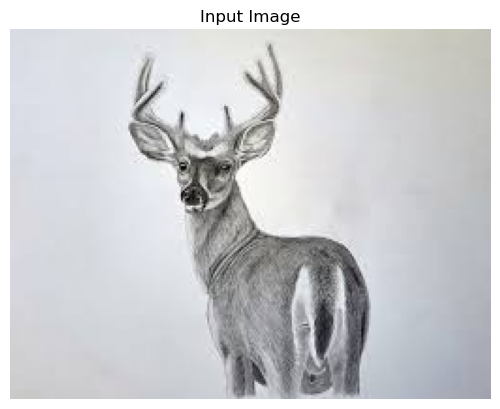


====== test2.jpg ======
pickup_truck         : 43.07%
lawn_mower           : 24.18%
tractor              : 16.30%
motorcycle           : 3.01%
tank                 : 2.44%


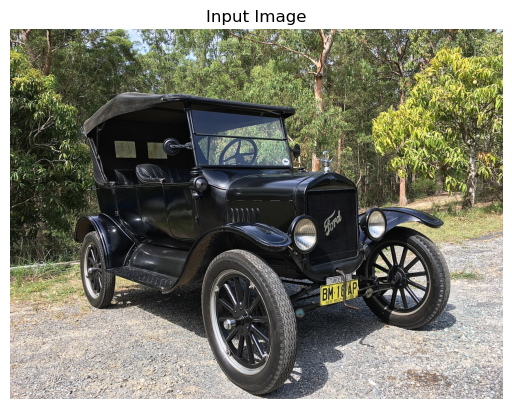


====== test3.jpg ======
pickup_truck         : 43.07%
lawn_mower           : 24.18%
tractor              : 16.30%
motorcycle           : 3.01%
tank                 : 2.44%


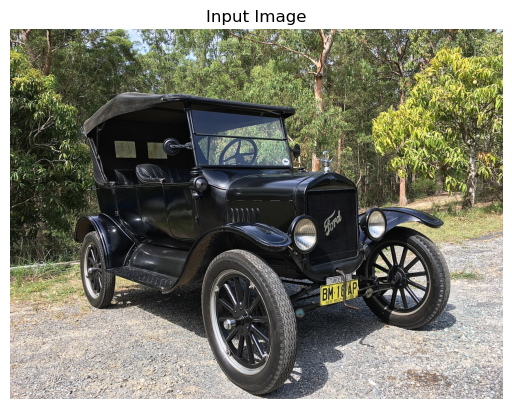


====== test1.jpg ======
dolphin              : 32.70%
mountain             : 13.33%
whale                : 10.33%
cloud                : 8.34%
shark                : 6.06%


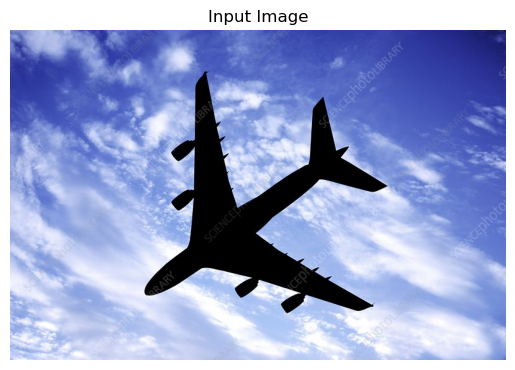


====== test4.jpeg ======
pickup_truck         : 92.84%
bus                  : 1.34%
lawn_mower           : 0.79%
tank                 : 0.56%
motorcycle           : 0.38%


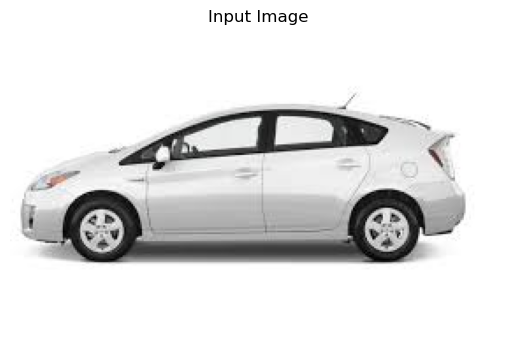


====== test6.jpeg ======
spider               : 97.11%
kangaroo             : 0.31%
cockroach            : 0.29%
beetle               : 0.18%
crab                 : 0.13%


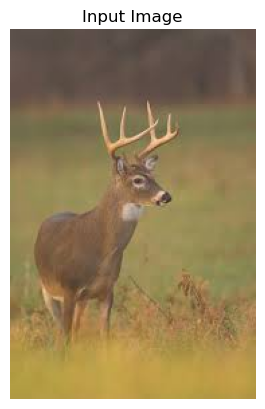


====== test7.jpg ======
bowl                 : 61.88%
tank                 : 11.98%
plate                : 7.61%
crab                 : 2.08%
lobster              : 1.55%


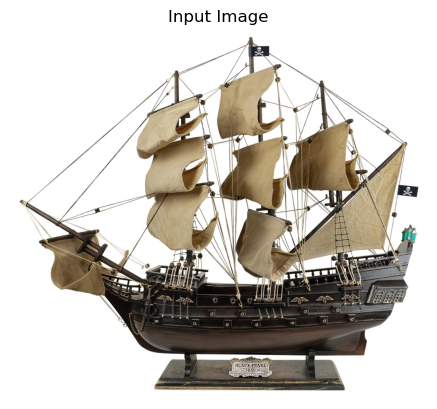

In [4]:
import torch
import torchvision
import torchvision.transforms as T
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# CIFAR-100 labels
CIFAR100_CLASSES = torchvision.datasets.CIFAR100(root="./data", download=True).classes

# ===== Model recreation =====
def get_tiny_student_model(num_classes=100):
    model = torchvision.models.mobilenet_v2(num_classes=num_classes, width_mult=0.5)
    model.features[0][0].stride = (1, 1)
    return model

# ===== Load trained student =====
model = get_tiny_student_model(100)
model.load_state_dict(torch.load("student_mobilenet_0.5x_best.pth", map_location=device))
model.to(device)
model.eval()

# ===== Inference transform =====
transform = T.Compose([
    T.Resize((32, 32)),
    T.ToTensor(),
    T.Normalize((0.5071, 0.4865, 0.4409),
                (0.2673, 0.2564, 0.2762))
])

# ===== Function to predict image =====
def predict(image_path):
    img = Image.open(image_path).convert("RGB")
    x = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        logits = model(x)
        probs = torch.softmax(logits, dim=1).cpu().numpy().squeeze()

    top5_idx = probs.argsort()[-5:][::-1]
    for idx in top5_idx:
        print(f"{CIFAR100_CLASSES[idx]:<20} : {probs[idx]*100:.2f}%")

    plt.imshow(img)
    plt.axis('off')
    plt.title("Input Image")
    plt.show()

# ===== Test any image =====
folder = "test_images/"
for f in os.listdir(folder):
    if f.lower().endswith(("jpg","jpeg","png")):
        print("\n======", f, "======")
        predict(os.path.join(folder, f))


Files already downloaded and verified

====== red-freight-train-locomotive-on-tracks-free-png.png ======


/home/shree/.local/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


tractor              : 21.77%
train                : 18.01%
lobster              : 14.97%
bus                  : 6.89%
caterpillar          : 4.19%


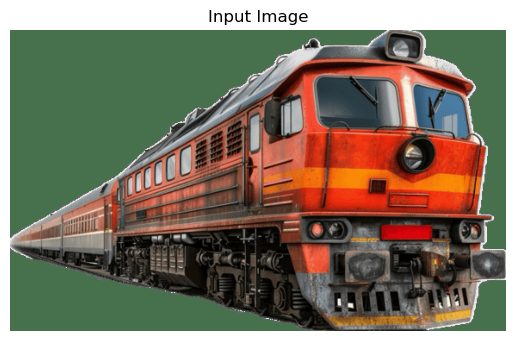


====== bee.png ======
bee                  : 99.54%
cockroach            : 0.15%
beetle               : 0.05%
lobster              : 0.03%
sunflower            : 0.03%


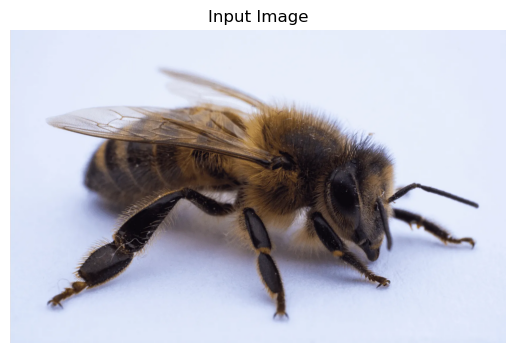


====== identify-and-get-rid-of-venmous-snakes.jpeg ======
snake                : 90.00%
leopard              : 2.12%
lizard               : 1.06%
lion                 : 0.90%
mushroom             : 0.78%


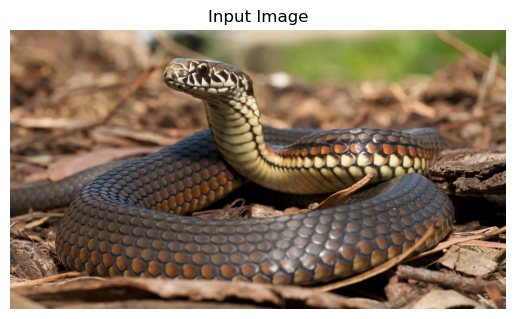


====== bee2.jpeg ======
beetle               : 76.25%
plate                : 3.63%
spider               : 2.79%
bowl                 : 1.93%
clock                : 1.80%


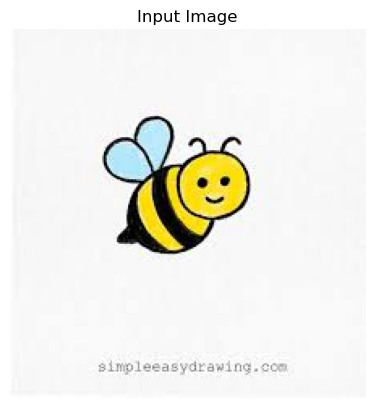


====== Untitled.jpeg ======
can                  : 97.96%
bottle               : 0.42%
streetcar            : 0.18%
clock                : 0.16%
telephone            : 0.08%


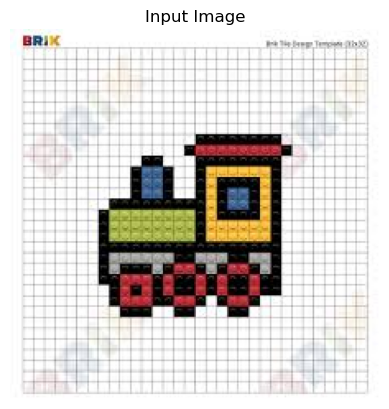


====== images.jpg ======
fox                  : 77.74%
tiger                : 19.30%
leopard              : 0.77%
cattle               : 0.36%
kangaroo             : 0.29%


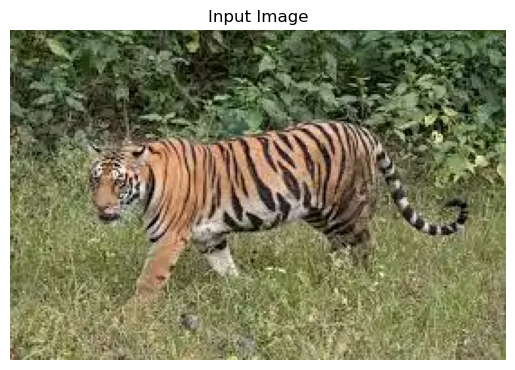


====== Southern_right_whale.jpg ======
whale                : 98.63%
dolphin              : 1.24%
seal                 : 0.01%
otter                : 0.01%
shark                : 0.01%


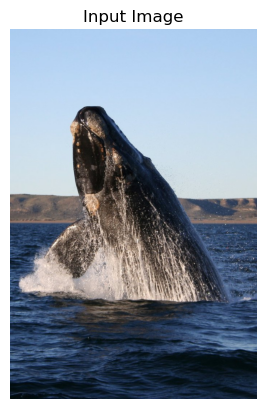

In [1]:
import torch
import torchvision
import torchvision.transforms as T
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# CIFAR-100 labels
CIFAR100_CLASSES = torchvision.datasets.CIFAR100(root="./data", download=True).classes

# ===== Model recreation =====
def get_tiny_student_model(num_classes=100):
    model = torchvision.models.mobilenet_v2(num_classes=num_classes, width_mult=0.5)
    model.features[0][0].stride = (1, 1)
    return model

# ===== Load trained student =====
model = get_tiny_student_model(100)
model.load_state_dict(torch.load("student_mobilenet_0.5x_best.pth", map_location=device))
model.to(device)
model.eval()

# ===== Inference transform =====
transform = T.Compose([
    T.Resize((32, 32)),
    T.ToTensor(),
    T.Normalize((0.5071, 0.4865, 0.4409),
                (0.2673, 0.2564, 0.2762))
])

# ===== Function to predict image =====
def predict(image_path):
    img = Image.open(image_path).convert("RGB")
    x = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        logits = model(x)
        probs = torch.softmax(logits, dim=1).cpu().numpy().squeeze()

    top5_idx = probs.argsort()[-5:][::-1]
    for idx in top5_idx:
        print(f"{CIFAR100_CLASSES[idx]:<20} : {probs[idx]*100:.2f}%")

    plt.imshow(img)
    plt.axis('off')
    plt.title("Input Image")
    plt.show()

# ===== Test any image =====
folder = "test_images1/"
for f in os.listdir(folder):
    if f.lower().endswith(("jpg","jpeg","png")):
        print("\n======", f, "======")
        predict(os.path.join(folder, f))


In [2]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import time
import os
import sys

# ==========================================
# 1. Model Architectures (Reconstructed)
# ==========================================

def get_teacher_resnet101(num_classes=100):
    """
    Reconstructs the Teacher ResNet101 as defined in resnet101.ipynb
    """
    # Initialize standard ResNet101
    # We use pretrained=False because we are about to load your custom weights anyway
    model = torchvision.models.resnet101(pretrained=False)

    # Modifications found in your notebook:
    # 1. Change first conv to accept 32x32 images without destroying info
    model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    
    # 2. Remove MaxPool to keep spatial dimensions
    model.maxpool = nn.Identity()
    
    # 3. Adjust FC layer for 100 classes
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    
    return model

def get_student_mobilenet(num_classes=100, width_mult=1.0):
    """
    Reconstructs the Student MobileNetV2 as defined in student_resnet101_upgraded.ipynb
    Used for both the 'Best' (1.0x) and 'Tiny' (0.5x) models.
    """
    # Initialize MobileNetV2
    model = torchvision.models.mobilenet_v2(num_classes=num_classes, width_mult=width_mult)
    
    # Modifications found in your notebook:
    # 1. CRITICAL FIX: Stride=1 in the first layer for CIFAR-100
    model.features[0][0].stride = (1, 1)
    
    return model

# ==========================================
# 2. Evaluation Utilities
# ==========================================

def load_weights(model, path, device):
    if not os.path.exists(path):
        print(f"[ERROR] Weight file not found: {path}")
        return False
        
    print(f"Loading weights from: {path} ...")
    try:
        checkpoint = torch.load(path, map_location=device)
        
        # Handle different saving methods (state_dict vs full checkpoint)
        if isinstance(checkpoint, dict) and 'state_dict' in checkpoint:
            state_dict = checkpoint['state_dict']
        else:
            state_dict = checkpoint
            
        # Load weights
        model.load_state_dict(state_dict)
        return True
    except Exception as e:
        print(f"[FAIL] Could not load weights: {e}")
        return False

def evaluate(model, dataloader, device, model_name):
    model.eval()
    correct = 0
    total = 0
    start_time = time.time()
    
    # Warmup (optional, helps stabilize timing for first batch)
    with torch.no_grad():
        dummy = torch.randn(1, 3, 32, 32).to(device)
        model(dummy)

    # Actual Inference Loop
    t0 = time.time()
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    t1 = time.time()
    inference_time = t1 - t0
    accuracy = 100 * correct / total
    
    return accuracy, inference_time

# ==========================================
# 3. Main Execution
# ==========================================

def main():
    # 1. Setup Device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Running on Device: {device}")
    
    # 2. Data Preparation (CIFAR-100 Test Set)
    print("\n[1/3] Preparing Data...")
    # Exact mean/std from your notebook
    stats = ((0.5071, 0.4865, 0.4409), (0.2673, 0.2564, 0.2762))
    
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(*stats),
    ])

    # Downloads dataset if not present
    testset = torchvision.datasets.CIFAR100(root='./data', train=False, 
                                            download=True, transform=transform_test)
    testloader = DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)
    print(f"Test Set Loaded: {len(testset)} images.")

    # 3. Define Models to Test
    models_config = [
        {
            "name": "Teacher (ResNet101)",
            "path": "savepoints/teacher_resnet101.pth",
            "model_fn": lambda: get_teacher_resnet101(num_classes=100)
        },
        {
            "name": "Student (MobileNetV2 1.0x)",
            "path": "student_mobilenet_cifar_best.pth",
            "model_fn": lambda: get_student_mobilenet(num_classes=100, width_mult=1.0)
        },
        {
            "name": "Tiny Student (MobileNetV2 0.5x)",
            "path": "student_mobilenet_0.5x_best.pth",
            "model_fn": lambda: get_student_mobilenet(num_classes=100, width_mult=0.5)
        }
    ]

    # 4. Run Evaluation
    print("\n[2/3] Starting Evaluation...")
    results = []
    
    for config in models_config:
        print(f"\nTesting {config['name']}...")
        model = config['model_fn']().to(device)
        
        if load_weights(model, config['path'], device):
            acc, duration = evaluate(model, testloader, device, config['name'])
            results.append({
                "name": config['name'],
                "acc": acc,
                "time": duration,
                "fps": len(testset) / duration
            })
            print(f"   -> Accuracy: {acc:.2f}% | Time: {duration:.2f}s")
        else:
            print(f"   -> Skipped (Weights missing)")

    # 5. Final Report
    print("\n[3/3] Final Comparison")
    print("="*75)
    print(f"{'Model Name':<30} | {'Accuracy':<10} | {'Time (s)':<10} | {'FPS':<10}")
    print("-" * 75)
    for res in results:
        print(f"{res['name']:<30} | {res['acc']:<9.2f}% | {res['time']:<9.2f}s | {res['fps']:<9.0f}")
    print("="*75)

if __name__ == "__main__":
    main()

Running on Device: cuda

[1/3] Preparing Data...
Files already downloaded and verified
Test Set Loaded: 10000 images.

[2/3] Starting Evaluation...

Testing Teacher (ResNet101)...


/home/shree/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/shree/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Loading weights from: savepoints/teacher_resnet101.pth ...
   -> Accuracy: 85.43% | Time: 11.91s

Testing Student (MobileNetV2 1.0x)...
Loading weights from: student_mobilenet_cifar_best.pth ...
   -> Accuracy: 69.02% | Time: 0.93s

Testing Tiny Student (MobileNetV2 0.5x)...
Loading weights from: student_mobilenet_0.5x_best.pth ...
   -> Accuracy: 67.86% | Time: 0.55s

[3/3] Final Comparison
Model Name                     | Accuracy   | Time (s)   | FPS       
---------------------------------------------------------------------------
Teacher (ResNet101)            | 85.43    % | 11.91    s | 840      
Student (MobileNetV2 1.0x)     | 69.02    % | 0.93     s | 10729    
Tiny Student (MobileNetV2 0.5x) | 67.86    % | 0.55     s | 18050    


Device: cuda
Loading models...
Scanning 'test_images1'...
Found 11 images. Processing...

Processing complete! Results saved to 'test_images1_results.png'


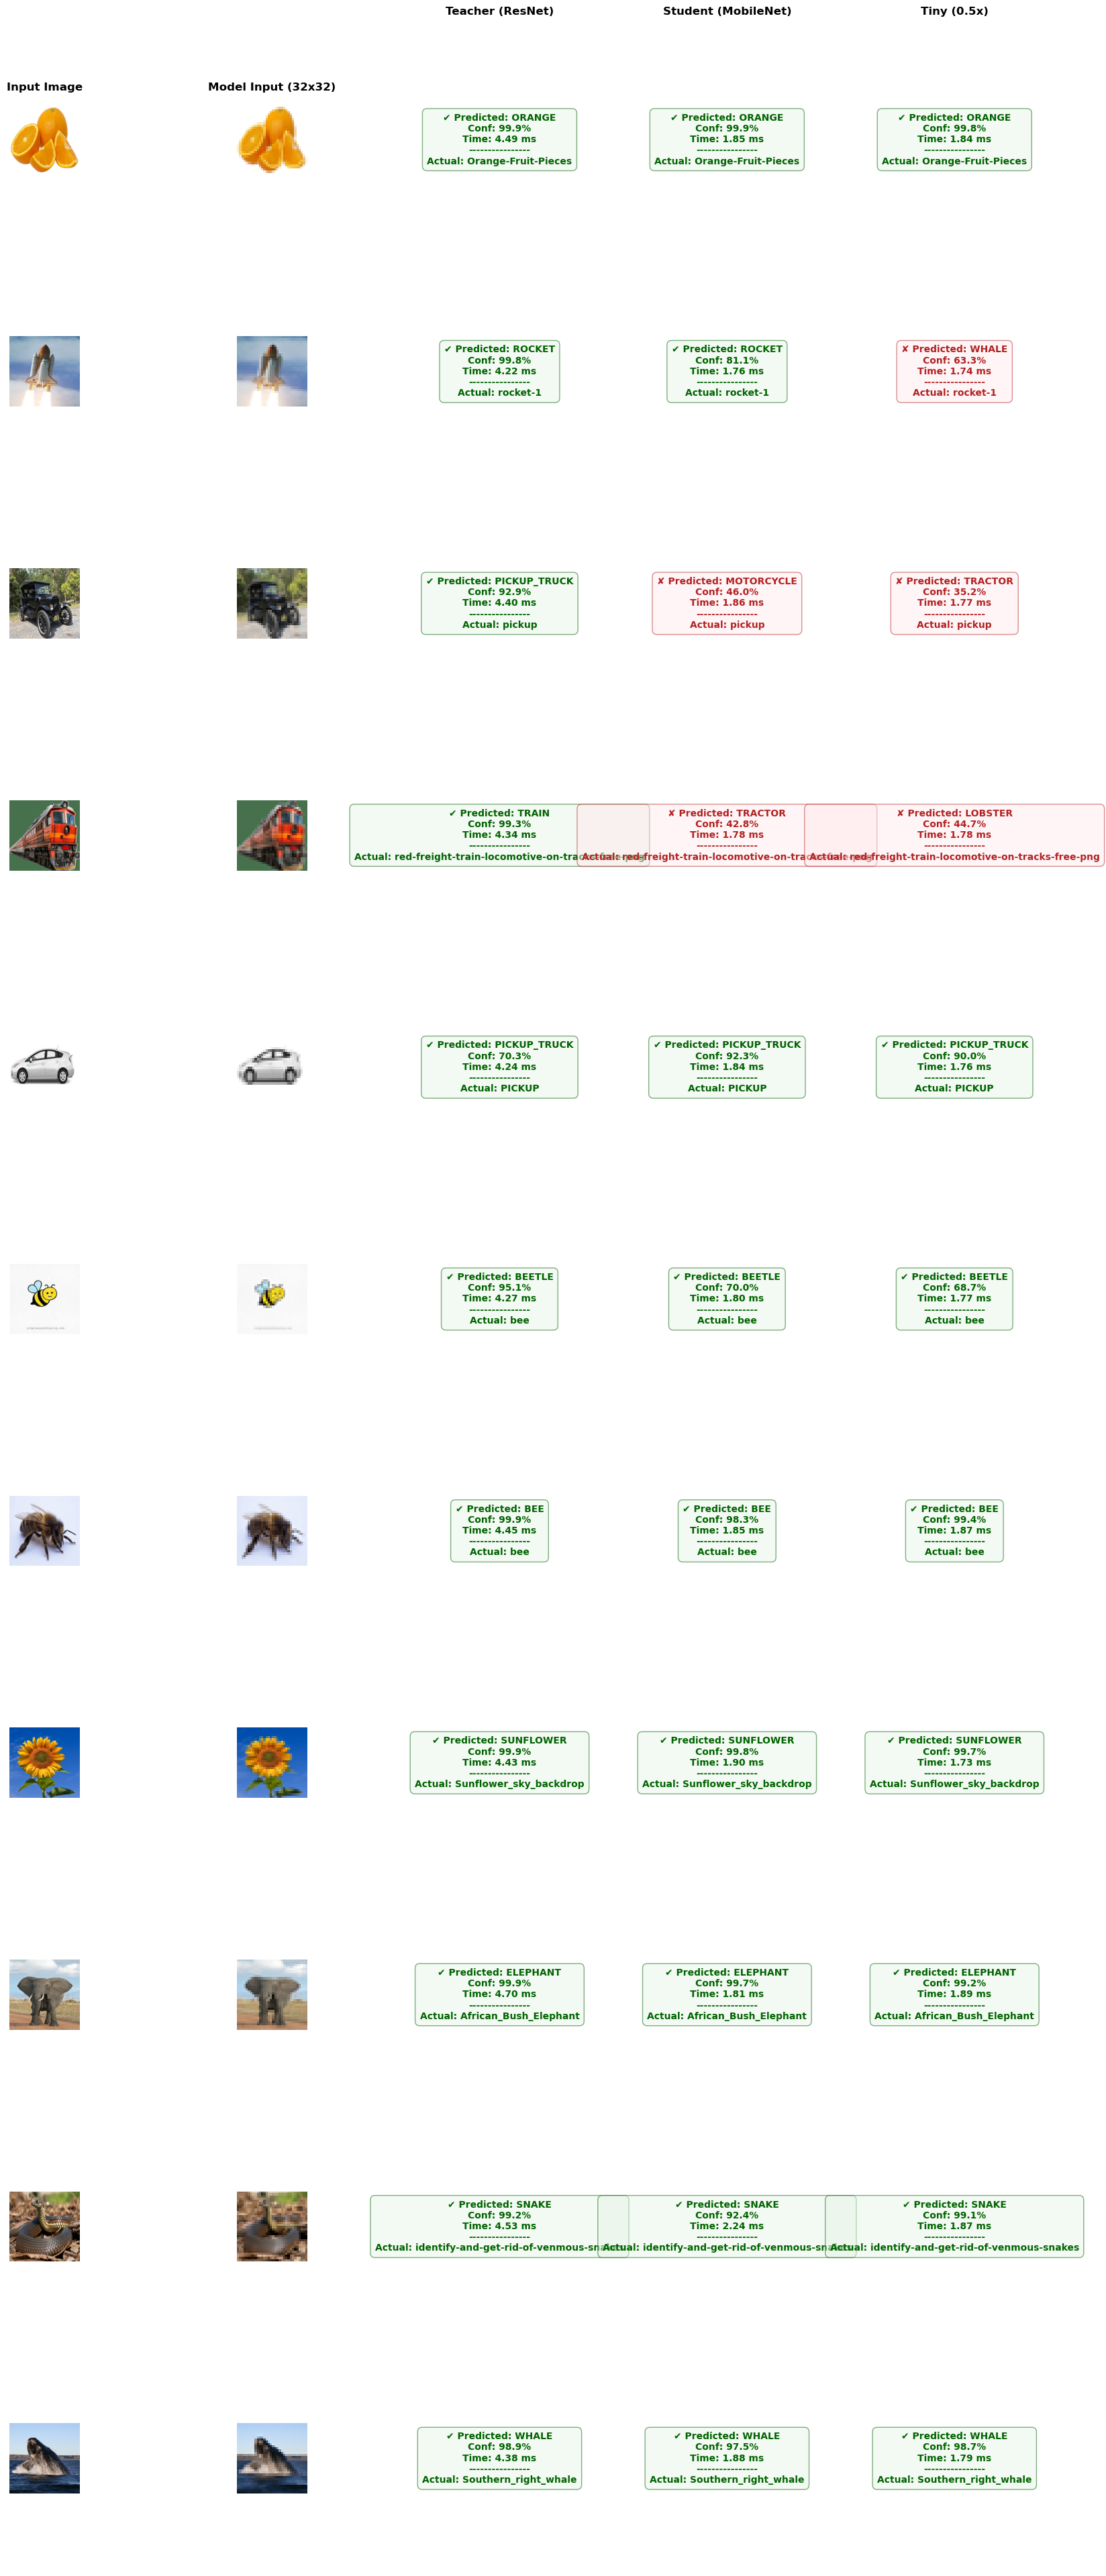

In [10]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image
import os
import glob
import time

# ==========================================
# 1. SETUP
# ==========================================
IMAGE_FOLDER = "test_images1"  # Folder name provided by you

# CIFAR-100 Classes
CIFAR100_CLASSES = [
    'apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 
    'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 
    'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 
    'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 
    'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 
    'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 
    'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 
    'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 
    'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 
    'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 
    'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 
    'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 
    'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 
    'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm'
]

# ==========================================
# 2. MODEL DEFINITIONS
# ==========================================
def get_teacher_resnet101(num_classes=100):
    model = torchvision.models.resnet101(pretrained=False)
    model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    model.maxpool = nn.Identity()
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model

def get_student_mobilenet(num_classes=100, width_mult=1.0):
    model = torchvision.models.mobilenet_v2(num_classes=num_classes, width_mult=width_mult)
    model.features[0][0].stride = (1, 1)
    return model

def load_weights(model, path, device):
    if not os.path.exists(path):
        print(f"[WARN] {path} not found. Using random weights.")
        return
    try:
        checkpoint = torch.load(path, map_location=device)
        state_dict = checkpoint['state_dict'] if 'state_dict' in checkpoint else checkpoint
        model.load_state_dict(state_dict)
    except Exception as e:
        print(f"[ERR] Error loading {path}: {e}")

# ==========================================
# 3. PREDICTION & VISUALIZATION
# ==========================================

def get_prediction_and_time(model, tensor, device):
    """Runs inference and measures time in milliseconds."""
    # Synchronize for accurate GPU timing if needed
    if device.type == 'cuda':
        torch.cuda.synchronize()
        
    start_t = time.time()
    
    with torch.no_grad():
        output = model(tensor)
        probs = torch.softmax(output, dim=1)
        conf, pred_idx = torch.max(probs, 1)
        
    if device.type == 'cuda':
        torch.cuda.synchronize()
        
    end_t = time.time()
    duration_ms = (end_t - start_t) * 1000 # Convert to milliseconds
    
    return CIFAR100_CLASSES[pred_idx.item()], conf.item(), duration_ms

def display_text_cell(ax, true_label, pred_label, confidence, duration_ms):
    ax.axis('off')
    
    # Check correctness (Case insensitive check against filename)
    is_correct = (true_label.lower() in pred_label.lower()) or (pred_label.lower() in true_label.lower())
    
    # Style configuration
    text_color = 'darkgreen' if is_correct else 'firebrick'
    bg_color = '#e8f5e9' if is_correct else '#ffebee'
    icon = "✔" if is_correct else "✘"
    
    # Text Content
    display_str = (
        f"{icon} Predicted: {pred_label.upper()}\n"
        f"Conf: {confidence*100:.1f}%\n"
        f"Time: {duration_ms:.2f} ms\n"  # Added Time Here
        f"----------------\n"
        f"Actual: {true_label}"
    )
    
    ax.text(0.5, 0.5, display_str, 
            ha='center', va='center', 
            fontsize=10, 
            color=text_color,
            weight='bold',
            bbox=dict(boxstyle="round,pad=0.5", fc=bg_color, ec=text_color, alpha=0.5))

# ==========================================
# 4. MAIN EXECUTION
# ==========================================
def main():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Device: {device}")

    # --- 1. Load Models ---
    print("Loading models...")
    teacher = get_teacher_resnet101().to(device)
    load_weights(teacher, "savepoints/teacher_resnet101.pth", device)
    teacher.eval()

    student = get_student_mobilenet(width_mult=1.0).to(device)
    load_weights(student, "student_mobilenet_cifar_best.pth", device)
    student.eval()

    tiny = get_student_mobilenet(width_mult=0.5).to(device)
    load_weights(tiny, "student_mobilenet_0.5x_best.pth", device)
    tiny.eval()

    # --- 2. Load Images from Folder ---
    if not os.path.exists(IMAGE_FOLDER):
        print(f"Error: Folder '{IMAGE_FOLDER}' does not exist.")
        return

    image_paths = glob.glob(os.path.join(IMAGE_FOLDER, "*"))
    # Filter for image extensions
    valid_extensions = {'.jpg', '.jpeg', '.png', '.bmp', '.webp'}
    valid_images = []
    
    print(f"Scanning '{IMAGE_FOLDER}'...")
    for p in image_paths:
        ext = os.path.splitext(p)[1].lower()
        if ext in valid_extensions:
            # Use filename (without extension) as the 'True Label'
            filename = os.path.basename(p)
            label = os.path.splitext(filename)[0]
            try:
                img = Image.open(p).convert('RGB')
                valid_images.append((img, label))
            except:
                print(f"Skipping corrupt file: {filename}")

    if not valid_images:
        print(f"No images found in {IMAGE_FOLDER}!")
        return
    
    print(f"Found {len(valid_images)} images. Processing...")

    # --- 3. Setup Visualization ---
    rows = len(valid_images)
    cols = 5
    fig, axes = plt.subplots(rows, cols, figsize=(16, 3.5 * rows))
    
    # Handle single image case (axes array shape differs)
    if rows == 1: axes = axes.reshape(1, -1)

    headers = ["Input Image", "Model Input (32x32)", "Teacher (ResNet)", "Student (MobileNet)", "Tiny (0.5x)"]
    for ax, header in zip(axes[0], headers):
        ax.set_title(header, fontsize=12, fontweight='bold', pad=15)

    # --- 4. Process Loop ---
    stats = ((0.5071, 0.4865, 0.4409), (0.2673, 0.2564, 0.2762))
    transform_norm = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(*stats)
    ])

    for i, (img, true_label) in enumerate(valid_images):
        # Resize
        img_highres = img.resize((150, 150))
        img_lowres = img.resize((32, 32))
        
        # Prepare Tensor
        input_tensor = transform_norm(img_lowres).unsqueeze(0).to(device)
        
        # Run Inference & Timing
        p_teach, c_teach, t_teach = get_prediction_and_time(teacher, input_tensor, device)
        p_stud, c_stud, t_stud    = get_prediction_and_time(student, input_tensor, device)
        p_tiny, c_tiny, t_tiny    = get_prediction_and_time(tiny, input_tensor, device)
        
        # Plot Images
        axes[i, 0].imshow(img_highres)
        axes[i, 0].axis('off')
        
        axes[i, 1].imshow(img_lowres)
        axes[i, 1].axis('off')
        
        # Plot Text with Time
        display_text_cell(axes[i, 2], true_label, p_teach, c_teach, t_teach)
        display_text_cell(axes[i, 3], true_label, p_stud, c_stud, t_stud)
        display_text_cell(axes[i, 4], true_label, p_tiny, c_tiny, t_tiny)

    plt.tight_layout()
    plt.savefig("test_images1_results.png")
    print("\nProcessing complete! Results saved to 'test_images1_results.png'")
    plt.show()

if __name__ == "__main__":
    main()